# Introduction

In this lab, we will demonstrate how to use L1-based regression models to deal with high-dimensional and sparse signals. In particular, we will compare three popular L1-based models: Lasso, Automatic Relevance Determination (ARD), and ElasticNet. We will use a synthetic dataset to illustrate the performance of these models in terms of fitting time, R2 score, and sparsity of estimated coefficients.

# Generate Synthetic Dataset

First, we generate a dataset where the number of samples is lower than the total number of features. This leads to an underdetermined system, i.e., the solution is not unique, and we cannot apply an ordinary least squares by itself. Regularization introduces a penalty term to the objective function, which modifies the optimization problem and can help alleviate the underdetermined nature of the system. We will generate a target **y** that is a linear combination with alternating signs of sinusoidal signals. Only the 10 lowest out of the 100 frequencies in **X** are used to generate **y**, while the rest of the features are not informative. This results in a high dimensional sparse feature space, where some degree of L1-penalization is necessary.

In [2]:
import numpy as np

rng = np.random.RandomState(0)
n_samples, n_features, n_informative = 50, 100, 10
time_step = np.linspace(-2, 2, n_samples)
freqs = 2 * np.pi * np.sort(rng.rand(n_features)) / 0.01
X = np.zeros((n_samples, n_features))

for i in range(n_features):
    X[:, i] = np.sin(freqs[i] * time_step)

idx = np.arange(n_features)
true_coef = (-1) ** idx * np.exp(-idx / 10)
true_coef[n_informative:] = 0  # sparsify coef
y = np.dot(X, true_coef)

# introduce random phase using numpy.random.random_sample
# add some gaussian noise using numpy.random.normal
for i in range(n_features):
    X[:, i] = np.sin(freqs[i] * time_step + 2 * (rng.random_sample() - 0.5))
    X[:, i] += 0.2 * rng.normal(0, 1, n_samples)

y += 0.2 * rng.normal(0, 1, n_samples)

# split the data into train and test sets using train_test_split from sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

# Lasso

In this step, we will demonstrate how to use Lasso regression model to estimate the sparse coefficients of the dataset. We will use a fixed value of the regularization parameter **alpha**. In practice, the optimal parameter **alpha** should be selected by passing a **TimeSeriesSplit** cross-validation strategy to a **LassoCV**. To keep the example simple and fast to execute, we directly set the optimal value for alpha here.

In [3]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from time import time

t0 = time()
lasso = Lasso(alpha=0.14).fit(X_train, y_train)
print(f"Lasso fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso r^2 on test data : {r2_score_lasso:.3f}")

Lasso fit done in 0.010s
Lasso r^2 on test data : 0.480


# Automatic Relevance Determination (ARD)

An ARD regression is the Bayesian version of the Lasso. It can produce interval estimates for all of the parameters, including the error variance, if required. It is a suitable option when the signals have Gaussian noise.

In [4]:
from sklearn.linear_model import ARDRegression

t0 = time()
ard = ARDRegression().fit(X_train, y_train)
print(f"ARD fit done in {(time() - t0):.3f}s")

y_pred_ard = ard.predict(X_test)
r2_score_ard = r2_score(y_test, y_pred_ard)
print(f"ARD r^2 on test data : {r2_score_ard:.3f}")

ARD fit done in 0.065s
ARD r^2 on test data : 0.541


# ElasticNet

ElasticNet is a middle ground between Lasso and Ridge regression, as it combines an L1 and an L2-penalty. The amount of regularization is controlled by the two hyperparameters **l1_ratio** and **alpha**. For **l1_ratio = 0** the penalty is pure L2 and the model is equivalent to a Ridge regression. Similarly, **l1_ratio = 1** is a pure L1 penalty and the model is equivalent to a Lasso regression. For **0 < l1_ratio < 1**, the penalty is a combination of L1 and L2.

In [5]:
from sklearn.linear_model import ElasticNet

t0 = time()
enet = ElasticNet(alpha=0.08, l1_ratio=0.5).fit(X_train, y_train)
print(f"ElasticNet fit done in {(time() - t0):.3f}s")

y_pred_enet = enet.predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(f"ElasticNet r^2 on test data : {r2_score_enet:.3f}")

ElasticNet fit done in 0.020s
ElasticNet r^2 on test data : 0.636


# Plot and Analysis of the Results

In this step, we use a heatmap to visualize the sparsity of the true and estimated coefficients of the respective linear models.

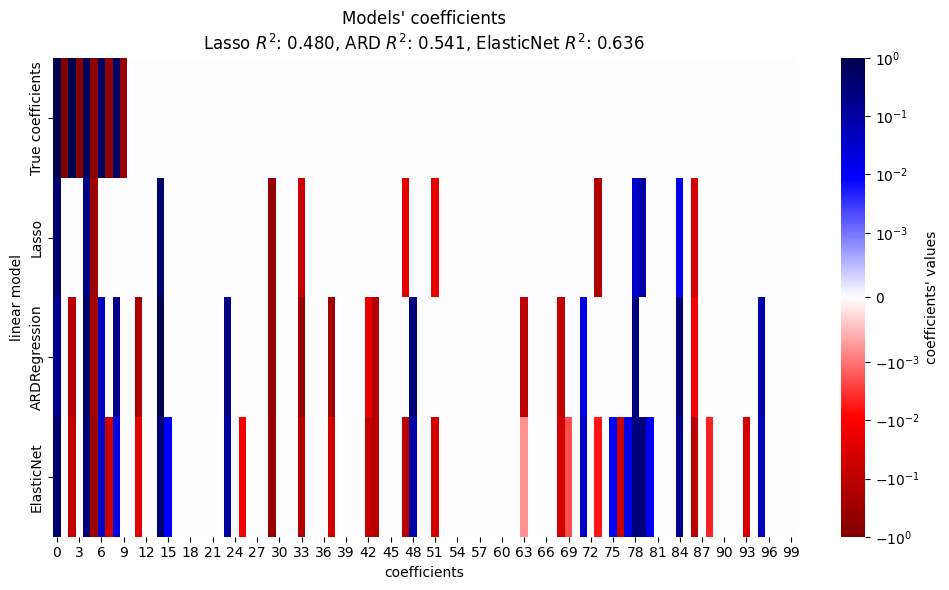

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import SymLogNorm

df = pd.DataFrame(
    {
        "True coefficients": true_coef,
        "Lasso": lasso.coef_,
        "ARDRegression": ard.coef_,
        "ElasticNet": enet.coef_,
    }
)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    df.T,
    norm=SymLogNorm(linthresh=10e-4, vmin=-1, vmax=1),
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r",
)
plt.ylabel("linear model")
plt.xlabel("coefficients")
plt.title(
    f"Models' coefficients\nLasso $R^2$: {r2_score_lasso:.3f}, "
    f"ARD $R^2$: {r2_score_ard:.3f}, "
    f"ElasticNet $R^2$: {r2_score_enet:.3f}"
)
plt.tight_layout()

# Summary

Lasso is known to recover sparse data effectively but does not perform well with highly correlated features. Indeed, if several correlated features contribute to the target, Lasso would end up selecting a single one of them. In the case of sparse yet non-correlated features, a Lasso model would be more suitable.

ElasticNet introduces some sparsity on the coefficients and shrinks their values to zero. Thus, in the presence of correlated features that contribute to the target, the model is still able to reduce their weights without setting them exactly to zero. This results in a less sparse model than a pure Lasso and may capture non-predictive features as well.

ARDRegression is better when handling Gaussian noise, but is still unable to handle correlated features and requires a larger amount of time due to fitting a prior.